## UPGMA for hooklog and Grouping
Read (jaccard) matrix from pickle and plot upgam.

Run parser-hooklog-matrix & parser-w32_mal_report-hooklogs first!

### Read pickle

In [1]:
parameter = True
windows = 1
upgma_threshold = 0.45
group_member_limit = 6
tag = '1246'
pickle_file_name = "hmatrix-%s-%s_w%d.pickle" % (tag, 'par' if parameter else 'nopar', windows)
save_file_name = "upgma-%s-%s-w%d-t%0.2f.pdf" % (tag, 'par' if parameter else 'nopar', windows, upgma_threshold)
group_member_file_name = "upgma-%s-%s-w%d-t%0.2f-gm%d.pickle" % (tag, 'par' if parameter else 'nopar', windows, upgma_threshold, group_member_limit)
print pickle_file_name, save_file_name, group_member_file_name

hmatrix-1246-par_w1.pickle upgma-1246-par-w1-t0.45.pdf upgma-1246-par-w1-t0.45-gm6.pickle


In [2]:
import pickle
import os

with open('pickle/av_list-mal_dict-proc_list.pickle', 'rb') as f:
    data = pickle.load(f)
proc_list = data[2]

with open('pickle/' + pickle_file_name, 'rb') as f:
    hmatrix = pickle.load(f)

In [3]:
#MIKE: filter proc_list here, if needed
p_list = proc_list

label_list = list()
for i in range(len(p_list)):
    digit = p_list[i][0:5]
    idx = 0
    for [d,x] in label_list:
        if d == digit:
            idx += 1
    label_list.append([digit, idx])

for i in range(len(label_list)):
    [digit, idx] = label_list[i]
    label_list[i] = digit + '-' + str(idx)

print len(p_list), len(label_list)

1246 1246


### UPGMA

In [4]:
import scipy
import scipy.cluster.hierarchy as sch
import matplotlib.pylab as plt
%matplotlib inline

matrix = [[0 for x in range(len(p_list))] for x in range(len(p_list))]

for i in p_list: # for each process we select
    idx_i = proc_list.index(i) # the idx in orig proc_list
    for j in p_list:
        idx_j = proc_list.index(j)
        matrix[p_list.index(i)][p_list.index(j)] = 1.0 - (hmatrix[idx_i][idx_j] if i<=j else hmatrix[idx_j][idx_i])

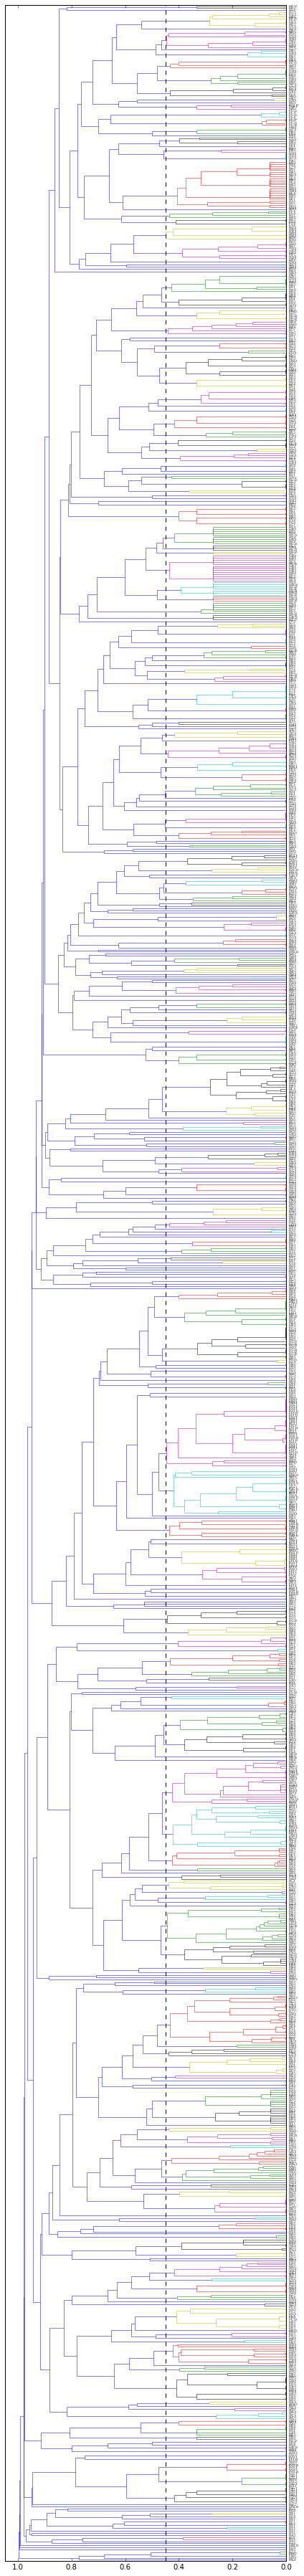

In [5]:
(orig_x, orig_y) = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = (6, 50)
plt.rcParams['lines.linewidth'] = 0.5
D = scipy.spatial.distance.squareform(matrix)
Z = sch.linkage(D, method='average')
#MIKE: Hack the height of tree, make sure we 
for z in Z:
    if z[2] < 0.002: z[2] = 0.002
P = sch.dendrogram(Z, color_threshold = upgma_threshold, labels = label_list, orientation = 'left')

plt.axvline(x=upgma_threshold, linewidth=1, color='black', linestyle='--')
#plt.xlim(0.7, 0.0)
#plt.ylabel('Distance')
locs, labels = plt.yticks()
plt.setp(labels, fontsize = 3 )
plt.tight_layout()

plt.rcParams['figure.figsize'] = (orig_x, orig_y)
plt.savefig('output/'+save_file_name, dpi=300)

### Grouping

In [6]:
group_dict = dict() # dict[current node] = (height, member set)
num_leaves = len(P['leaves'])

for l in range(num_leaves):
    curr_set = set()
    curr_set.add(l)
    group_dict[l] = (-1.0, curr_set)

next_group = num_leaves
for z in Z:
    a = int(z[0])
    b = int(z[1])
    h = z[2]
        
    if h > upgma_threshold:
        continue
        
    #print a, b, '=>', next_group, '@', h
    
    # merge a and b to next_group
    curr_set = group_dict[a][1].union(group_dict[b][1])
    group_dict[next_group] = (h, curr_set)
    # remove a and b
    del group_dict[a]
    del group_dict[b]
    next_group += 1

In [7]:
print 'Total', len(group_dict), 'groups @ threshold = ', upgma_threshold

group_member_dict = dict()
g_set = set()
m_count = 0
for g in group_dict:
    node_name = P['ivl'][P['leaves'].index(g)] if g < num_leaves else g
    o = "== group %d head %s @ %f size %d" % (g, node_name, group_dict[g][0], len(group_dict[g][1]))
    m_set = set()
    for m in group_dict[g][1]:
        if m < num_leaves:
            member_name = P['ivl'][P['leaves'].index(m)]
            m_set.add(member_name)
            g_set.add(member_name)
        else:
            member_name = m
        #print '  process', m, member_name
    o += " unique %d malware" % (len(m_set))
    m_count += len(m_set)
    
    # output
    print o
    if len(m_set) > group_member_limit: #MIKE: group that has > ? members
        li = list()
        for m in m_set:
            li.append(p_list[label_list.index(m)])
        group_member_dict[g] = (group_dict[g][0], li)

print 'total malware', len(g_set), 'but', m_count, 'group by group'

Total 357 groups @ threshold =  0.45
== group 13 head ffff9-0 @ -1.000000 size 1 unique 1 malware
== group 16 head fffb2-0 @ -1.000000 size 1 unique 1 malware
== group 31 head fffd1-0 @ -1.000000 size 1 unique 1 malware
== group 39 head fffe1-0 @ -1.000000 size 1 unique 1 malware
== group 45 head fffed-0 @ -1.000000 size 1 unique 1 malware
== group 60 head fff7c-1 @ -1.000000 size 1 unique 1 malware
== group 68 head ffff2-1 @ -1.000000 size 1 unique 1 malware
== group 69 head ff666-0 @ -1.000000 size 1 unique 1 malware
== group 71 head ffffa-0 @ -1.000000 size 1 unique 1 malware
== group 73 head ffdd2-0 @ -1.000000 size 1 unique 1 malware
== group 81 head ffff9-1 @ -1.000000 size 1 unique 1 malware
== group 88 head fff66-1 @ -1.000000 size 1 unique 1 malware
== group 91 head ffdc8-0 @ -1.000000 size 1 unique 1 malware
== group 99 head bc7f1-1 @ -1.000000 size 1 unique 1 malware
== group 106 head ffff8-0 @ -1.000000 size 1 unique 1 malware
== group 109 head fffa9-0 @ -1.000000 size 1 un

In [8]:
GIL = (group_dict, P['ivl'], P['leaves'], upgma_threshold, windows)

import pickle
with open('pickle/group-ivl-leaves-th.pickle', 'wb') as o:
    pickle.dump(GIL, o)

In [9]:
import pickle
# dict = {group_number: (height, [memberlist])}
with open('pickle/'+group_member_file_name, 'wb') as o:
    pickle.dump(group_member_dict, o)

In [10]:
print len(group_member_dict)
group_member_dict

51


{1812: (0.16666666666666666,
  ['5ee1ed1d1c3dbbb3e920e56229023080_3448',
   '5ee1ed1d1c3dbbb3e920e56229023080_3468',
   '11dbaa09f5b949c9d6e0db7e157cc860_3380',
   '11dbaa09f5b949c9d6e0db7e157cc860_3564',
   '80cf51208fbee22191e5590038b0df80_3272',
   '4c73c216e72a1ec198cd99f4ee96d2d0_3328',
   '80cf51208fbee22191e5590038b0df80_3296']),
 1870: (0.22360248416666667,
  ['fffe4c7c2a714c4484de8a38564d76f0_3128',
   'fffc84bb695f8ba7c7164ef9c69ba480_3260',
   'fffd8b29c3dd098db963012a44917d10_3112',
   'fff8be7d8dd737679512d74bb4ffb520_3112',
   'fffed8d8b8ccbd65f5ea16e54adb61d0_3188',
   'ff85d3f8443ba214f3adf4a6227aa5a5_3248',
   'fffdb22ca58e4211c28ab52e54380ec0_3124']),
 1909: (0.265801621875,
  ['fffd0d4ba5a5191c99c4230a9b2fc930_3236',
   'ffff653512ab48ebc0351515ad934ac0_3284',
   'fff6da05279f6909e0c5445612c6bfc0_3168',
   'fffeab12697deecd6e76640a3a57b700_3212',
   'ffff809e7b5a3284ce924696241be7a0_3176',
   'ffff14b75aff6098a07c30d75a4deae0_3156',
   'fffd7b7f3dde2d0bc0b20cb5d0d527